In [2]:
!pip install torch torchvision


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download MNIST
train_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train → train + validation
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 64.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


In [5]:
class CNN_NoDropout(nn.Module):
    def __init__(self):
        super(CNN_NoDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
class CNN_WithDropout(nn.Module):
    def __init__(self):
        super(CNN_WithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [7]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        total, correct, running_loss = 0, 0, 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        train_loss_list.append(running_loss / len(train_loader))
        train_acc_list.append(100 * correct / total)

        # Validation
        model.eval()
        total, correct, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

        val_loss_list.append(val_loss / len(val_loader))
        val_acc_list.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}]  Train Acc: {train_acc_list[-1]:.2f}%  Val Acc: {val_acc_list[-1]:.2f}%")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list


In [8]:
criterion = nn.CrossEntropyLoss()

# No Dropout Model
model_no = CNN_NoDropout()
optimizer_no = optim.SGD(model_no.parameters(), lr=0.01, momentum=0.9)

loss_no_train, loss_no_val, acc_no_train, acc_no_val = train_and_validate(model_no, train_loader, val_loader, optimizer_no, criterion)



Epoch [1/10]  Train Acc: 88.33%  Val Acc: 96.10%
Epoch [2/10]  Train Acc: 97.77%  Val Acc: 97.97%
Epoch [3/10]  Train Acc: 98.43%  Val Acc: 98.41%
Epoch [4/10]  Train Acc: 98.69%  Val Acc: 98.57%
Epoch [5/10]  Train Acc: 99.03%  Val Acc: 98.58%
Epoch [6/10]  Train Acc: 99.09%  Val Acc: 98.86%
Epoch [7/10]  Train Acc: 99.33%  Val Acc: 98.79%
Epoch [8/10]  Train Acc: 99.39%  Val Acc: 98.87%
Epoch [9/10]  Train Acc: 99.51%  Val Acc: 98.98%
Epoch [10/10]  Train Acc: 99.56%  Val Acc: 98.99%


In [9]:
# With Dropout Model
model_do = CNN_WithDropout()
optimizer_do = optim.SGD(model_do.parameters(), lr=0.01, momentum=0.9)

loss_do_train, loss_do_val, acc_do_train, acc_do_val = train_and_validate(model_do, train_loader, val_loader, optimizer_do, criterion)

Epoch [1/10]  Train Acc: 83.69%  Val Acc: 97.16%
Epoch [2/10]  Train Acc: 96.30%  Val Acc: 97.82%
Epoch [3/10]  Train Acc: 97.30%  Val Acc: 98.28%
Epoch [4/10]  Train Acc: 97.83%  Val Acc: 98.60%
Epoch [5/10]  Train Acc: 98.11%  Val Acc: 98.78%
Epoch [6/10]  Train Acc: 98.35%  Val Acc: 98.83%
Epoch [7/10]  Train Acc: 98.46%  Val Acc: 98.86%
Epoch [8/10]  Train Acc: 98.60%  Val Acc: 98.78%
Epoch [9/10]  Train Acc: 98.74%  Val Acc: 99.01%
Epoch [10/10]  Train Acc: 98.83%  Val Acc: 98.99%


In [10]:
def test_accuracy(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    return 100 * correct / total

acc_test_no = test_accuracy(model_no)
acc_test_do = test_accuracy(model_do)

print(f"Test Accuracy (No Dropout): {acc_test_no:.2f}%")
print(f"Test Accuracy (With Dropout): {acc_test_do:.2f}%")


Test Accuracy (No Dropout): 99.00%
Test Accuracy (With Dropout): 99.11%


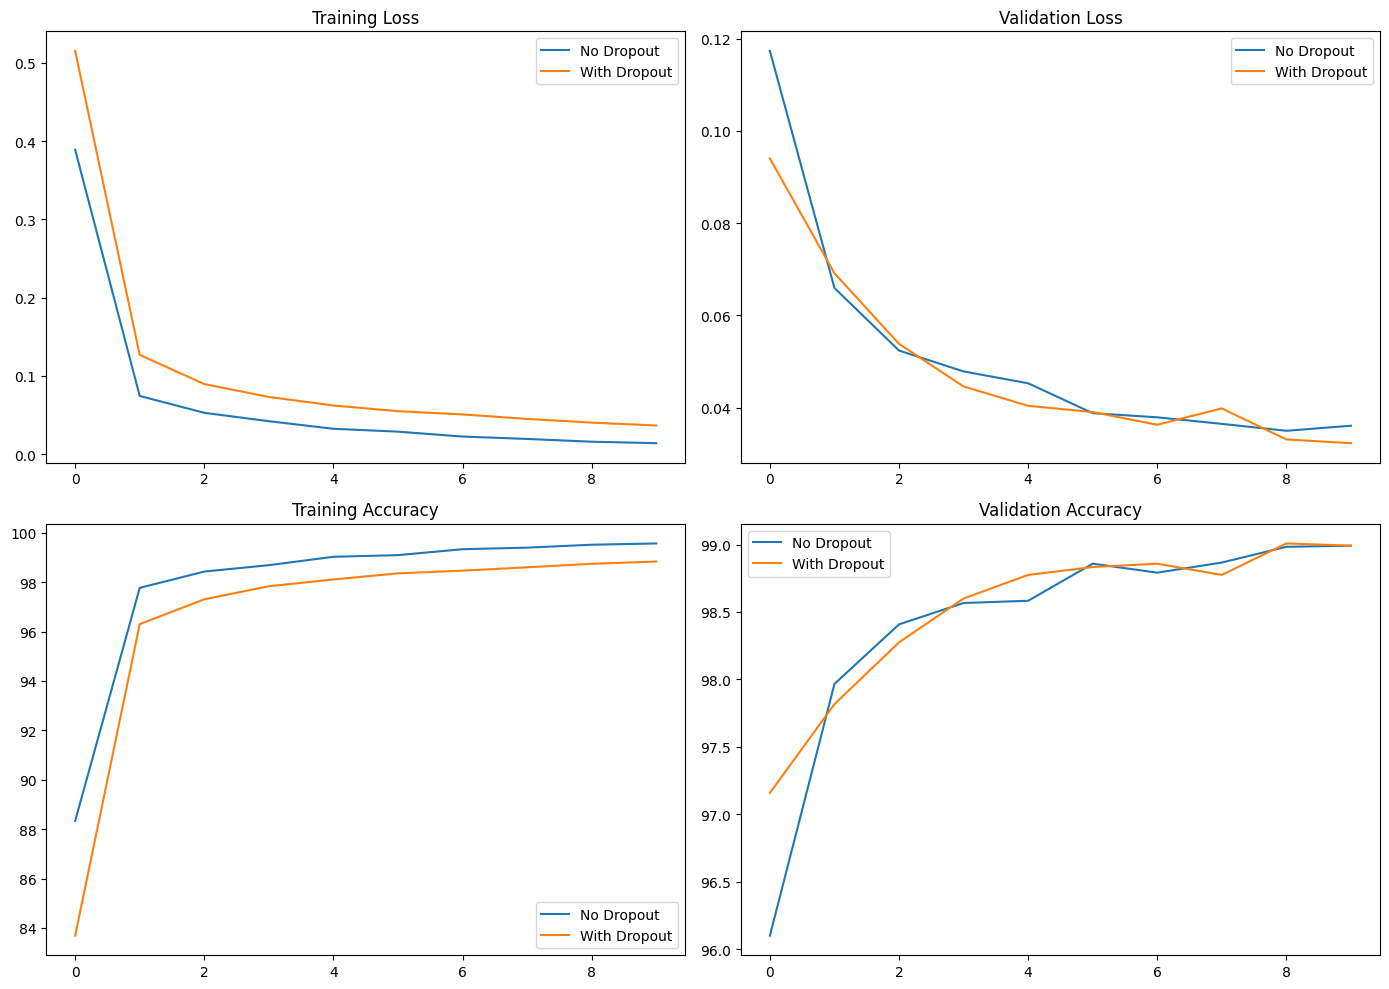

In [11]:
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(loss_no_train, label='No Dropout')
plt.plot(loss_do_train, label='With Dropout')
plt.title("Training Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(loss_no_val, label='No Dropout')
plt.plot(loss_do_val, label='With Dropout')
plt.title("Validation Loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(acc_no_train, label='No Dropout')
plt.plot(acc_do_train, label='With Dropout')
plt.title("Training Accuracy")
plt.legend()

plt.subplot(2,2,4)
plt.plot(acc_no_val, label='No Dropout')
plt.plot(acc_do_val, label='With Dropout')
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
